# Анализ результатов A/B-теста в интернет-магазине

### Оглавление

1. [Описание проекта](#projekt) 
2. [Цель и задачи проекта](#purpose)     
3. [Описание данных](#data)    
4. [Открытие данных и изучение общей информации](#start)
5. [Подготовка данных](#preparation)   
6. [Исследование данных](#analysis)    
  6.1. [Приоритизация гипотез](#hypothesis)   
  6.2. [Анализ A/B-теста](#test)   
7. [Общий вывод](#conclusion)
8. [Рекомендации](#recommendations)

### Описание проекта
<a name="projekt"></a>

Вместе с отделом маркетинга интернет-магазина подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

### Цель и задачи проекта
<a name="purpose"></a>

Цель проекта - подготовить рекомендации по увеличению выручки интернет-магазина на основе результатов A/B-теста.
<br>Для этого необходимо провести:     
1. Приоритизацию гипотез:  
  - применить фреймворк ICE;  
  - применить фреймворк RICE;  
  - указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.    
2. Анализ A/B-теста:    
  - построить график кумулятивной выручки по группам;  
  - построить график кумулятивного среднего чека по группам;  
  - построить график относительного изменения кумулятивного среднего чека группы B к группе A; 
  - построить график кумулятивной конверсии по группам;  
  - построить график относительного изменения кумулятивной конверсии группы B к группе A;  
  - построить точечный график количества заказов по пользователям;  
  - посчитать 95-й и 99-й перцентили количества заказов на пользователя, выбрать границу для определения аномальных пользователей;  
  - построить точечный график стоимостей заказов;  
  - посчитать 95-й и 99-й перцентили стоимости заказов, выбрать границу для определения аномальных заказов;  
  - посчитать статистическую значимость различий в конверсии между группами по «сырым» данным;  
  - посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным;  
  - посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным;    
  - посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным;  
  - принять решение по результатам теста.

### Описание данных
<a name="data"></a>

#### Таблица hypothesis

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале (чем больше значение Efforts, тем дороже проверка гипотезы).

#### Таблица orders

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

#### Таблица visitors

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

### Открытие данных и изучение общей информации
<a name="start"></a>

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline         
plt.rcParams.update({'font.size': 16})
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
from pylab import rcParams
rcParams['figure.figsize'] = 18, 9
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 120
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

#### Таблица hypothesis

In [4]:
# прочитаем DataFrame
try:
    hypothesis = pd.read_csv('hypothesis.csv')  # локальный путь
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')  # путь на сервере

In [5]:
# выведем на экран таблицу
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
# посмотрим сводную информацию таблицы
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице 9 строк, 5 столбцов, тип данных у одного столбца строковый, у остальных - целочисленный. В названии столбцов есть строчные буквы.

In [7]:
# посмотрим количество уникальных значений по столбцам таблицы
for column in hypothesis.columns:
    print(column)
    print()
    print(hypothesis[column].value_counts())
    print()        

Hypothesis

Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар             1
Запустить акцию, дающую скидку на товар в день рождения                                                         1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                                1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей              1
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысит

В столбце `Hypothesis` во фразе "Изменить структура категорий..." слово "структура" должно быть указано в винительном падеже - "структуру". В столбцах `Reach`, `Impact`, `Confidence` и `Efforts` указаны параметры фреймворка RICE по 10-бальной шкале. 

In [8]:
# определим количество пропущенных значений в таблице
hypothesis.isnull().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Пропущенные значения отсутствуют.

In [9]:
# посчитаем количество дубликатов
hypothesis.duplicated().sum()

0

Дубликаты отсутствуют.

#### Таблица orders

In [10]:
# прочитаем DataFrame
try:
    orders = pd.read_csv('orders.csv')  # локальный путь
except:
    orders = pd.read_csv('/datasets/orders.csv')  # путь на сервере

In [11]:
# выведем на экран 10 случайных строк таблицы
orders.sample(10)

,transactionId,visitorId,date,revenue,group
494,1207030791,2700013943,2019-08-26,1980,B
450,1750160666,1333886533,2019-08-06,1460,A
1063,842507644,3170292896,2019-08-11,1190,B
1125,4099032419,2749453459,2019-08-13,5390,A
28,2632372083,3591136796,2019-08-15,5280,B
1192,2662137336,3733762160,2019-08-14,6490,B
269,1067267410,3957174400,2019-08-18,2480,A
755,1234615529,2279926127,2019-08-30,45780,B
828,1029192242,570540961,2019-08-30,2690,B
20,2904772834,963407295,2019-08-15,300,B


In [12]:
# посмотрим сводную информацию таблицы
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице 1197 строк, 5 столбцов, тип данных у двух столбцов строковый, у остальных - целочисленный. В названии столбцов есть строчные буквы. В столбце `date` значения даты заказа указаны не в формате `datetime`.

In [13]:
# посмотрим количество уникальных значений по столбцам таблицы
for column in orders.columns:
    print(column)
    print()
    print(orders[column].value_counts())
    print()        

transactionId

3574407166    1
2470658885    1
1476831880    1
3709669952    1
2764584088    1
             ..
1168756094    1
1185885568    1
11068804      1
486237576     1
1192185169    1
Name: transactionId, Length: 1197, dtype: int64

visitorId

4256040402    11
2458001652    11
2378935119     9
2038680547     8
3717692402     5
              ..
3254689071     1
4186744110     1
1455861274     1
3612778094     1
3149228032     1
Name: visitorId, Length: 1031, dtype: int64

date

2019-08-05    48
2019-08-12    47
2019-08-14    47
2019-08-15    46
2019-08-06    46
2019-08-01    45
2019-08-28    45
2019-08-02    44
2019-08-27    44
2019-08-08    43
2019-08-19    43
2019-08-29    42
2019-08-07    42
2019-08-09    41
2019-08-22    41
2019-08-26    41
2019-08-03    40
2019-08-23    40
2019-08-10    39
2019-08-16    38
2019-08-21    37
2019-08-30    35
2019-08-13    35
2019-08-04    33
2019-08-20    32
2019-08-31    32
2019-08-24    31
2019-08-18    26
2019-08-11    26
2019-08-25    24
2

Общее количество заказов - 1197, уникальных покупателей - 1031, покупатели произвели от 1 до 11 заказов, количество заказов в день - от 24 до 48. 640 покупок осуществили покупатели из группы "В", 557 - из группы "А".

In [14]:
# проведем базовую проверку столбца с выручкой 
orders['revenue'].describe()

count       1,197.00
mean        8,348.01
std        39,191.13
min            50.00
25%         1,220.00
50%         2,978.00
75%         8,290.00
max     1,294,500.00
Name: revenue, dtype: float64

В среднем выручка от одного заказа составляет 8348 рублей, минимальная выручка от одного заказа - 50 рублей, максимальная - 1294500 рублей.

In [15]:
# определим период информации в таблице
orders['date'].min(), orders['date'].max()

('2019-08-01', '2019-08-31')

В таблице представлена информация с 01.08.2019 по 31.08.2019.

In [16]:
# определим количество пропущенных значений в таблице
orders.isnull().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Пропущенные значения отсутствуют.

In [17]:
# посчитаем количество дубликатов
orders.duplicated().sum()

0

Дубликаты отсутствуют.

#### Таблица visitors

In [18]:
# прочитаем DataFrame
try:
    visitors = pd.read_csv('visitors.csv')  # локальный путь
except:
    visitors = pd.read_csv('/datasets/visitors.csv')  # путь на сервере

In [19]:
# выведем на экран 10 случайных строк таблицы
visitors.sample(10)

,date,group,visitors
41,2019-08-11,B,721
30,2019-08-31,A,699
4,2019-08-05,A,756
31,2019-08-01,B,713
29,2019-08-30,A,490
24,2019-08-25,A,621
51,2019-08-21,B,656
10,2019-08-11,A,718
34,2019-08-04,B,770
48,2019-08-18,B,737


In [20]:
# посмотрим сводную информацию таблицы
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице 62 строки, 3 столбца, тип данных у двух столбцов строковый, у одного - целочисленный. В столбце `date` значения даты посещения указаны не в формате `datetime`.

In [21]:
# посмотрим количество уникальных значений по столбцам таблицы
for column in visitors.columns:
    print(column)
    print()
    print(visitors[column].value_counts())
    print()        

date

2019-08-20    2
2019-08-06    2
2019-08-25    2
2019-08-05    2
2019-08-22    2
2019-08-14    2
2019-08-04    2
2019-08-09    2
2019-08-17    2
2019-08-28    2
2019-08-01    2
2019-08-27    2
2019-08-08    2
2019-08-21    2
2019-08-18    2
2019-08-12    2
2019-08-10    2
2019-08-03    2
2019-08-15    2
2019-08-02    2
2019-08-23    2
2019-08-16    2
2019-08-24    2
2019-08-19    2
2019-08-11    2
2019-08-07    2
2019-08-26    2
2019-08-29    2
2019-08-31    2
2019-08-13    2
2019-08-30    2
Name: date, dtype: int64

group

A    31
B    31
Name: group, dtype: int64

visitors

610    2
718    2
654    2
490    2
509    1
575    1
699    1
709    1
361    1
560    1
679    1
421    1
676    1
546    1
544    1
543    1
722    1
707    1
668    1
667    1
406    1
531    1
656    1
655    1
395    1
650    1
646    1
644    1
770    1
577    1
711    1
581    1
617    1
378    1
413    1
746    1
502    1
628    1
756    1
369    1
412    1
621    1
748    1
619    1
487    1
507    

В таблице указана ежедневная информация о посещениях сайта по двум группам - "А" и "В".

In [22]:
# определим период информации в таблице
visitors['date'].min(), visitors['date'].max()

('2019-08-01', '2019-08-31')

В таблице представлена информация с 01.08.2019 по 31.08.2019.

In [23]:
# определим количество пропущенных значений в таблице
visitors.isnull().sum()

date        0
group       0
visitors    0
dtype: int64

Пропущенные значения отсутствуют.

In [24]:
# посчитаем количество дубликатов
visitors.duplicated().sum()

0

Дубликаты отсутствуют.

### Вывод

При изучении таблиц с данными установлено следующее:

1. Таблица `hypothesis`:  
  - в таблице 9 строк, 5 столбцов, пропущенные значения и дубликаты отсутствуют;   
  - тип данных у одного столбца строковый, у остальных - целочисленный;
  - в столбцах `Reach`, `Impact`, `Confidence` и `Efforts` указаны параметры фреймворка RICE по 10-бальной шкале;  
  - в столбце `Hypothesis` во фразе "Изменить структура категорий..." слово "структура" должно быть указано в винительном падеже - "структуру";   
  - в названии столбцов есть строчные буквы.
2. Таблица `orders`:
  - в таблице 1197 строк, 5 столбцов, пропущенные значения и дубликаты отсутствуют;   
  - тип данных у двух столбцов строковый, у остальных - целочисленный;  
  - в таблице содержится информация за период с 01.08.2019 по 31.08.2019;  
  - в среднем выручка от одного заказа составляет 8348 рублей, минимальная выручка от одного заказа - 50 рублей, максимальная - 1294500 рублей;  
  - общее количество заказов - 1197, уникальных покупателей - 1031, покупатели произвели от 1 до 11 заказов, количество заказов в день - от 24 до 48, 640 покупок осуществили покупатели из группы "В", 557 - из группы "А";   
  - в названии столбцов есть строчные буквы;
  - в столбце `date` значения даты заказа указаны не в формате `datetime`.  
3. Таблица `visitors`:
  - в таблице 62 строки, 3 столбца, пропущенные значения и дубликаты отсутствуют;   
  - тип данных у двух столбцов строковый, у одного - целочисленный;  
  - в таблице содержится информация за период с 01.08.2019 по 31.08.2019;  
  - в таблице указана ежедневная информация о посещениях сайта по двум группам - "А" и "В";   
  - в столбце `date` значения даты посещения указаны не в формате `datetime`.  

Проанализировав вышеизложенное, необходимо выполнить следующее:   
1. названия столбцов в таблицах `hypothesis` и `orders` привести к нижнему регистру;    
2. в столбце `Hypothesis` таблицы `hypothesis` во фразе "Изменить структура категорий..." слово "структура" указать в винительном падеже;   
3. значения даты заказа в таблице `orders` и даты посещения в таблице `visitors` привести к формату `datetime`.

### Подготовка данных
<a name="preparation"></a>

#### Таблица hypothesis

In [25]:
# приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [26]:
# поменяем фразу "Изменить структура категорий..."
hypothesis['hypothesis'][3] = hypothesis['hypothesis'][3].replace('структура', 'структуру')
hypothesis['hypothesis'][3]

'Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар'

#### Таблица orders

In [27]:
# приведем названия столбцов к нижнему регистру
orders =  orders.rename(columns = {'transactionId':'transaction_id',
                                   'visitorId':'visitor_id'})
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [28]:
# приведем значения даты заказа к формату "datetime"
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


#### Таблица visitors

In [29]:
# приведем значения даты посещения к формату "datetime"
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


В целях подготовки данных провели следующую работу:  
1. названия столбцов в таблицах `hypothesis` и `orders` привели к нижнему регистру;    
2. в столбце `Hypothesis` таблицы `hypothesis` во фразе "Изменить структура категорий..." слово "структура" указали в винительном падеже;   
3. значения даты заказа в таблице `orders` и даты посещения в таблице `visitors` привели к формату `datetime`.

### Исследование данных
<a name="analysis"></a>

#### Приоритизация гипотез
<a name="hypothesis"></a>

In [30]:
# добавим в таблицу столбец с сокращенными названиями гипотез
hypothesis['hypothesis_reduced'] = ['Новые каналы трафика',
                                    'Собственная служба доставки',
                                    'Блоки рекомендаций товаров',
                                    'Изменение структуры категорий',
                                    'Фон главной страницы',
                                    'Страница отзывов клиентов',
                                    'Баннеры на главной странице',
                                    'Форма подписки на страницы',
                                    'Акция в день рождения']
hypothesis

,hypothesis,reach,impact,confidence,efforts,hypothesis_reduced
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,Новые каналы трафика
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,Собственная служба доставки
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,Блоки рекомендаций товаров
3,"Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,Изменение структуры категорий
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,Фон главной страницы
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,Страница отзывов клиентов
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,Баннеры на главной странице
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,Форма подписки на страницы
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,Акция в день рождения


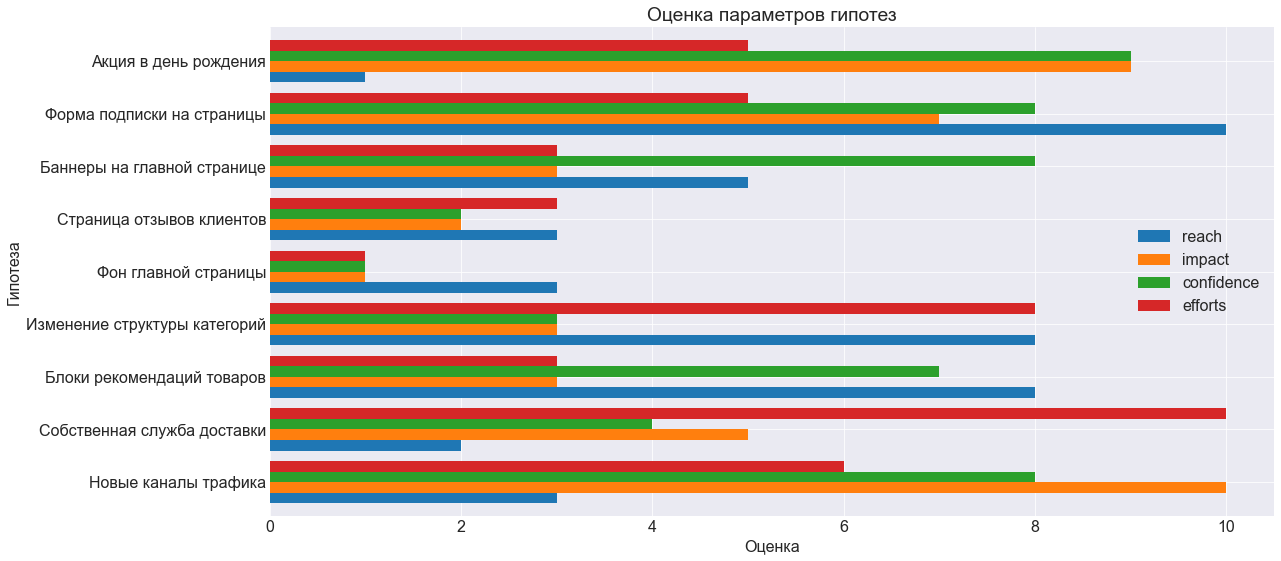

In [31]:
# посмотрим на оценку параметров гипотез
ax = hypothesis[['reach', 'impact', 'confidence', 'efforts']].plot.barh(width = 0.8)
ax.set(title = 'Оценка параметров гипотез',
       xlabel = 'Оценка',
       ylabel = 'Гипотеза')
plt.yticks(np.arange(9),
            hypothesis['hypothesis_reduced'])
plt.show()

1. Самая высокая оценка по параметру охвата пользователей у гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", самая низкая у гипотезы "Запустить акцию, дающую скидку на товар в день рождения".  
2. Самая высокая оценка по параметру влияния изменения метрики на пользователей у гипотезы "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", самая низкая у гипотезы "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей".  
3. Самая высокая оценка по параметру уверенности в оценках других параметров у гипотезы "Запустить акцию, дающую скидку на товар в день рождения", самая низкая у гипотезы "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей".  
4. Самая высокая оценка по параметру сложности проверки у гипотезы "Запустить собственную службу доставки, что сократит срок доставки заказов", самая низкая у гипотезы "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей". 

##### Применить фреймворк ICE

Формула способа приоритизации гипотез ICE:  
<br>

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [32]:
# применим фреймворк ICE для приоритизации гипотез
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_ICE = hypothesis[['hypothesis',
                              'ICE',
                              'hypothesis_reduced']].sort_values(by = 'ICE',
                                                                 ascending = False)\
                                                    .reset_index(drop = True)
hypothesis_ICE[['hypothesis', 'ICE']]

,hypothesis,ICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
7,"Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [33]:
# применим фреймворк RICE для приоритизации гипотез
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_RICE = hypothesis[['hypothesis',
                              'RICE',
                              'hypothesis_reduced']].sort_values(by = 'RICE',
                                                                 ascending = False)\
                                                    .reset_index(drop = True)
hypothesis_RICE[['hypothesis', 'RICE']]

,hypothesis,RICE
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
4,"Запустить акцию, дающую скидку на товар в день рождения",16.20
5,"Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


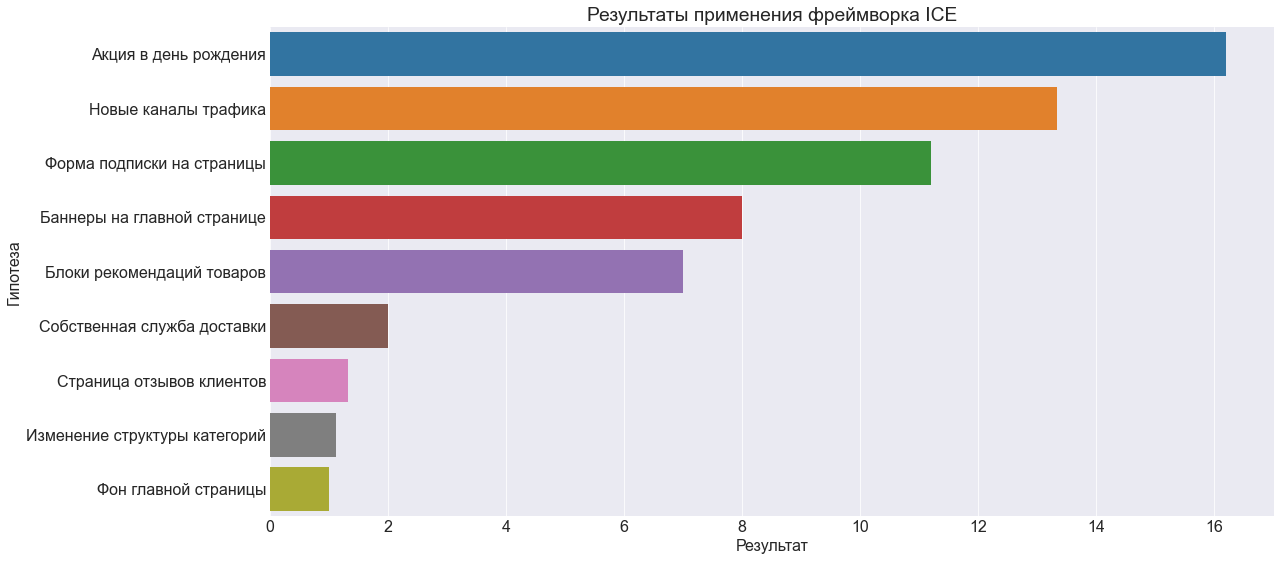

In [34]:
# посмотрим на результаты применения фреймворка ICE
fig, ax = plt.subplots()
plt.title('Результаты применения фреймворка ICE')
ax = sns.barplot(x = 'ICE',
                 y = 'hypothesis',
                 data = hypothesis_ICE)       
plt.xlabel('Результат')
plt.ylabel('Гипотеза')
ax.set_yticklabels(labels = hypothesis_ICE['hypothesis_reduced'])
plt.show()

Наиболее приоритетные гипотезы по фреймворку ICE:

1. Запустить акцию, дающую скидку на товар в день рождения.
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Наименее приоритетные гипотезы по фреймворку ICE:

1. Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей.   
2. Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар.
3. Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов.

##### Применить фреймворк RICE

Формула способа приоритизации гипотез RICE:  
<br>

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [35]:
# применим фреймворк RICE для приоритизации гипотез
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_RICE = hypothesis[['hypothesis',
                              'RICE',
                              'hypothesis_reduced']].sort_values(by = 'RICE',
                                                                 ascending = False)\
                                                    .reset_index(drop = True)
hypothesis_RICE[['hypothesis', 'RICE']]

,hypothesis,RICE
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
4,"Запустить акцию, дающую скидку на товар в день рождения",16.20
5,"Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


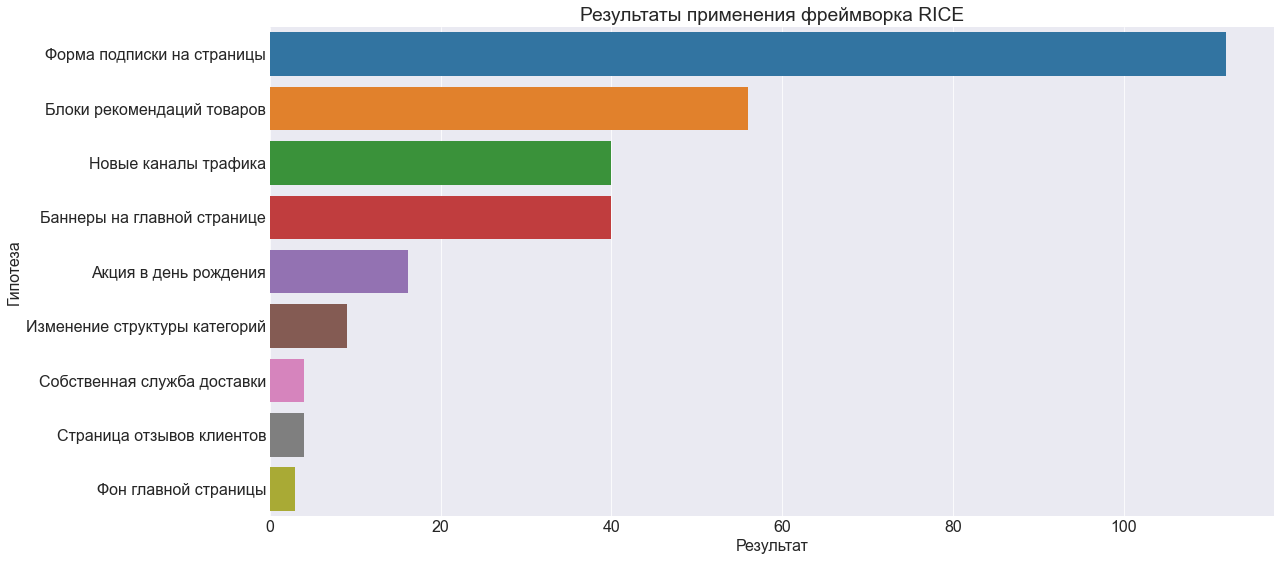

In [36]:
# посмотрим на результаты применения фреймворка RICE
fig, ax = plt.subplots()
plt.title('Результаты применения фреймворка RICE')
ax = sns.barplot(x = 'RICE',
                 y = 'hypothesis',
                 data = hypothesis_RICE)       
plt.xlabel('Результат')
plt.ylabel('Гипотеза')
ax.set_yticklabels(labels = hypothesis_RICE['hypothesis_reduced'])
plt.show()

Наиболее приоритетные гипотезы по фреймворку RICE:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.   
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Наименее приоритетные гипотезы по фреймворку RICE:

1. Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей.   
2. Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов.
3. Запустить собственную службу доставки, что сократит срок доставки заказов.

##### Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE

При применении фреймворка RICE самой приоритетной гипотезой стала гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", поскольку у этой гипотезы самая высокая оценка по параметру охвата пользователей. Самая приоритетная гипотеза по фреймворку ICE "Запустить акцию, дающую скидку на товар в день рождения" имеет самый низкий показатель охвата пользователей, в связи с чем по фреймворку RICE в список наиболее приоритетных не попала. В этот список и по фреймворку RICE, и по фреймворку ICE попала гипотеза "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", имеющая достаточно низкую оценку по параметру охвата аудитории. Высокие показатели охвата вывели гипотезы "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" и "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" по фреймворку RICE в список наиболее приоритетных.   
Высокая оценка по параметру охвата пользователей позволила  гипотезе "Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар" не попасть в список наименее приоритетных гипотез по фреймворку RICE. В то же время в этот список попала гипотеза "Запустить собственную службу доставки, что сократит срок доставки заказов", имеющая одну из самых низких оценок по параметру охвата пользователей. Гипотезы "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей" и "Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов" и по фреймворку RICE, и по фреймворку ICE в списке наименее приоритетных гипотез.

#### Вывод

С учетом влияния всех факторов:  
- наиболее приоритетными гипотезами являются:  
  1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
  2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
  3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.   
  4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.  
  5. Запустить акцию, дающую скидку на товар в день рождения (учитывая низкую оценку по параметру затрат ресурсов на проверку гипотез).
- наименее приоритетными гипотезами являются:  
  1. Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей.   
  2. Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов.
  3. Запустить собственную службу доставки, что сократит срок доставки заказов.  

#### Анализ A/B-теста
<a name="test"></a>

Проверим, что одни и те же пользователи, осуществлявшие заказы, не попали в две разные группы (группу A и группу B), а также значения выручки на нормальность распределения.

In [37]:
# найдем количество пользователей, попавших в две разные группы
orders_A = orders.query('group == "A"')['visitor_id']\
                 .unique()
orders_B = orders.query('group == "B"')['visitor_id']\
                 .unique()
orders_AB = orders[orders['visitor_id'].isin(orders_A)\
                   & orders['visitor_id'].isin(orders_B)]['visitor_id']
orders_AB.nunique()

58

In [38]:
# найдем долю пользователей, попавших в две разные группы
round(orders_AB.nunique() / orders['visitor_id'].nunique() * 100, 1)

5.6

In [39]:
# найдем долю заказов, совершенных пользователями, попавшими в две разные группы
round(orders[orders['visitor_id'].isin(orders_AB)]['transaction_id'].count() / orders['transaction_id'].count() * 100, 1)

15.1

58 пользователей (5,6%) попало в две разные группы (группу A и группу B), этими пользователями совершено 15,1% заказов. Для большей достоверности A/B-теста их следовало бы исключить, однако в таблице `visitors` эти пользователи попали в обе группы, причём неизвестно, в какие даты. Таким образом, удалив их,  мы не сможем учесть это при работе с информацией о посещениях. В связи с этим, данные с пользователями, попавшими в две разные группы, следует оставить, но принять это во внимание при подведении результатов A/B-теста. 

In [40]:
# проверим значения выручки на нормальность распределения
alpha = .05 
results = stats.shapiro(orders['revenue'])
p_value = results[1]
print('p-значение: ', p_value)
if (p_value < alpha):
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Распределение выручки не нормально, это следует учесть при выборе метода для проверки гипотез.

##### Построить график кумулятивной выручки по группам 

In [41]:
# создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date',
                       'group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [42]:
# получим агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                       orders['group'] == x['group'])]\
                                .agg({'date' : 'max',
                                      'group' : 'max',
                                      'transaction_id' : pd.Series.nunique,
                                      'visitor_id' : pd.Series.nunique,
                                      'revenue' : 'sum'}),
                                       axis = 1)\
                                .sort_values(by = ['date',
                                                   'group'])
orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [43]:
# получим агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                           visitors['group'] == x['group'])]\
                                  .agg({'date' : 'max',
                                        'group' : 'max',
                                        'visitors' : 'sum'}),
                                         axis = 1)\
                                  .sort_values(by = ['date',
                                                     'group'])
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [44]:
# объединим кумулятивные данные в одной таблице
cumulative_data = orders_aggregated.merge(visitors_aggregated,
                                          left_on = ['date',
                                                     'group'],
                                          right_on = ['date',
                                                      'group'])
cumulative_data.columns = ['date',
                           'group',
                           'orders',
                           'buyers',
                           'revenue',
                           'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [45]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date',
                                                                         'revenue',
                                                                         'orders']]
cumulative_revenue_A.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [46]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date',
                                                                         'revenue',
                                                                         'orders']]
cumulative_revenue_B.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


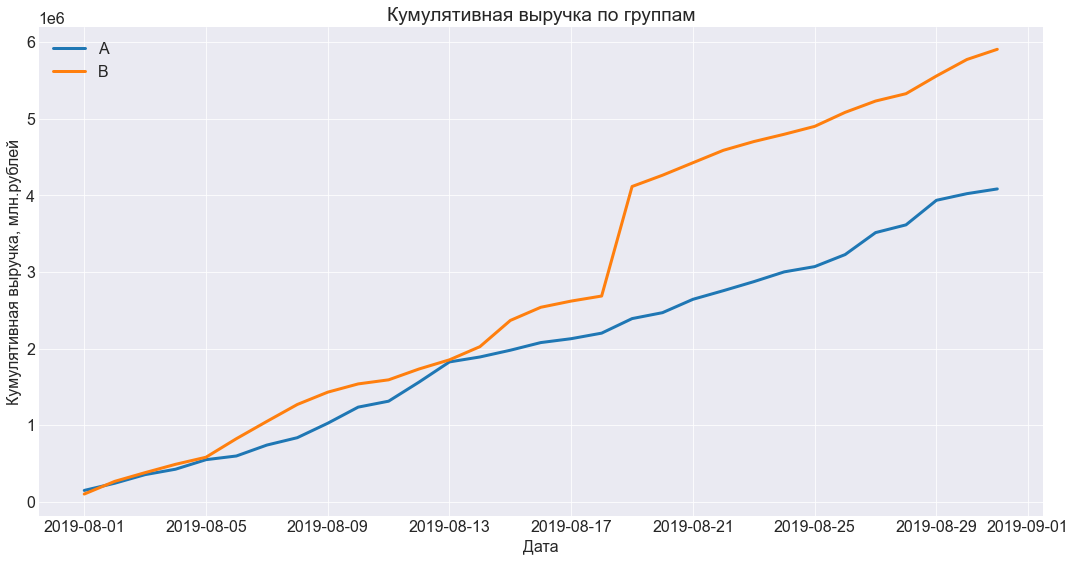

In [47]:
# построим график кумулятивной выручки по группам 
fig, ax = plt.subplots()
plt.title('Кумулятивная выручка по группам')
ax = sns.lineplot(x = 'date',
                  y = 'revenue',
                  data = cumulative_revenue_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'revenue',
                  data = cumulative_revenue_B,
                  label = 'B',
                  linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, млн.рублей')
ax.legend()
plt.show() 

Выручка у покупателей из обеих групп почти равномерно увеличивалась до середины теста. Затем сегмент B вырвался вперед и продолжал лидировать до конца теста. При этом график выручки группы B в нескольких точках резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Кроме того, следует учесть большее количество пользователей в группе B.

##### Построить график кумулятивного среднего чека по группам

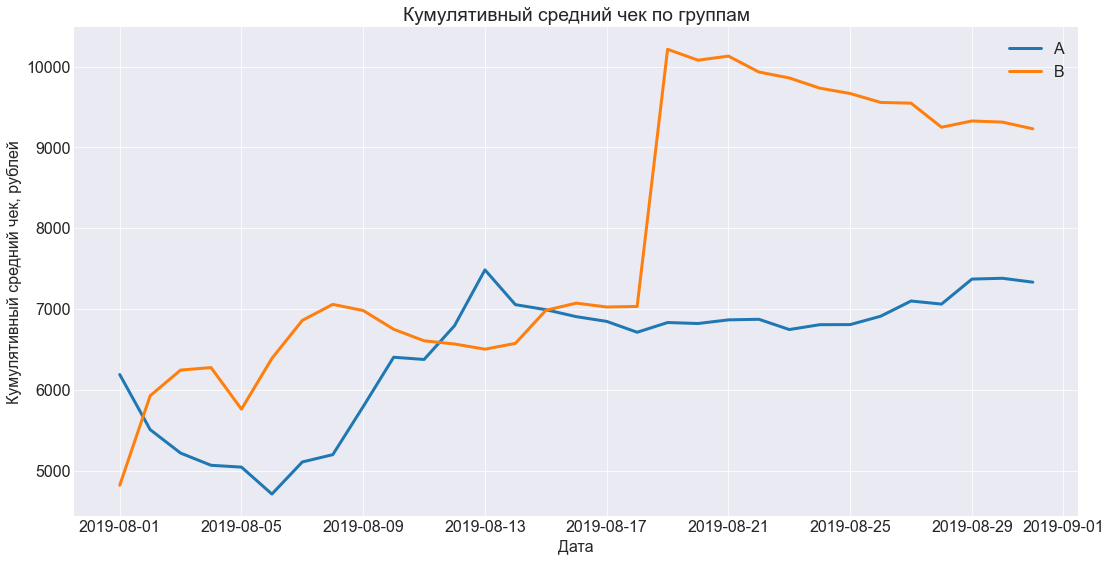

In [48]:
# построим график кумулятивного среднего чека по группам 
cumulative_revenue_A['fee_mean'] = cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders']
cumulative_revenue_B['fee_mean'] = cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders']
fig, ax = plt.subplots()
plt.title('Кумулятивный средний чек по группам')
ax = sns.lineplot(x = 'date',
                  y = 'fee_mean',
                  data = cumulative_revenue_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'fee_mean',
                  data = cumulative_revenue_B,
                  label = 'B',
                  linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, рублей')
ax.legend()
plt.show()

Средний чек в группе A становится равномерным примерно с середины теста, а в группе B после значительного всплеска начинает медленно уменьшаться. Принимать решение по этой метрике рано, следует провести дополнительный анализ выбросов, которые искажают результаты.

##### Построить  график относительного изменения кумулятивного среднего чека группы B к группе A

In [49]:
# объединим данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B,
                                                       left_on = 'date',
                                                       right_on = 'date',
                                                       how = 'left',
                                                       suffixes = ['A', 'B'])
merged_cumulative_revenue.head()

,date,revenueA,ordersA,fee_meanA,revenueB,ordersB,fee_meanB
0,2019-08-01,148579,24,"6,190.79",101217,21,"4,819.86"
1,2019-08-02,242401,44,"5,509.11",266748,45,"5,927.73"
2,2019-08-03,354874,68,"5,218.74",380996,61,"6,245.84"
3,2019-08-04,425699,84,"5,067.85",489567,78,"6,276.50"
4,2019-08-05,549917,109,"5,045.11",581995,101,"5,762.33"


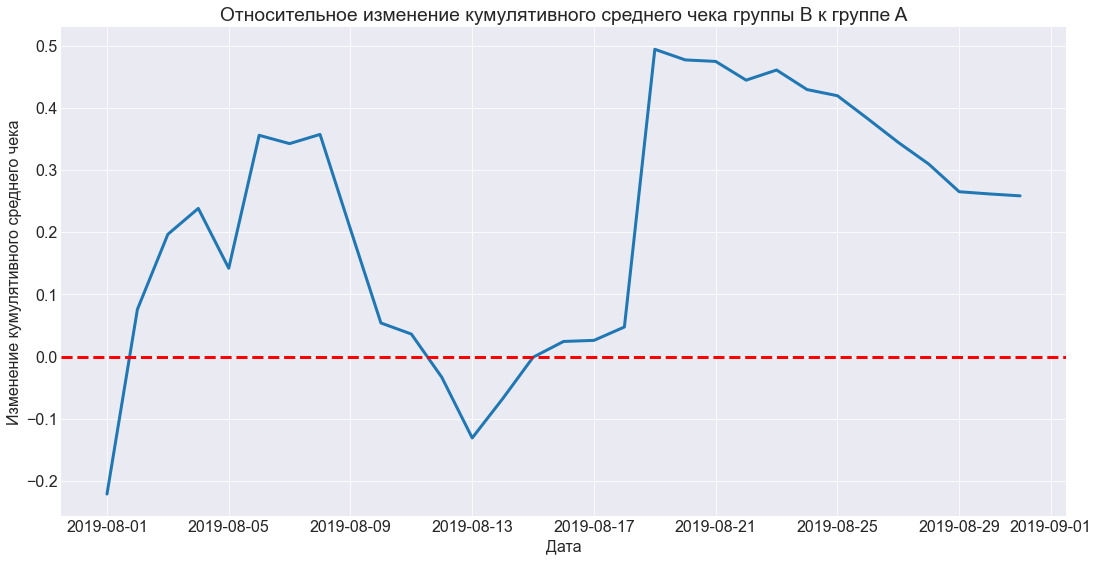

In [50]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A 
merged_cumulative_revenue['fee_relation'] = merged_cumulative_revenue['fee_meanB'] / merged_cumulative_revenue['fee_meanA'] - 1
fig, ax = plt.subplots()
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
ax = sns.lineplot(x = 'date',
                  y = 'fee_relation',
                  data = merged_cumulative_revenue,
                  linewidth = 3)
plt.axhline(y = 0,
            color = 'red',
            linestyle = '--',
            linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивного среднего чека')
plt.show()

В нескольких точках график различия между группами резко «скачет», максимальные всплески были 06.08. и 19.08.2019. Вероятнее всего именно в эти дни совершены аномальные заказы. 

##### Построить график кумулятивной конверсии по группам

In [51]:
# посчитаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.03
1,2019-08-01,B,21,20,101217,713,0.03
2,2019-08-02,A,44,38,242401,1338,0.03
3,2019-08-02,B,45,43,266748,1294,0.03
4,2019-08-03,A,68,62,354874,1845,0.04


In [52]:
# сделаем срез данных по группе A
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_A.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.03
2,2019-08-02,A,44,38,242401,1338,0.03
4,2019-08-03,A,68,62,354874,1845,0.04
6,2019-08-04,A,84,77,425699,2562,0.03
8,2019-08-05,A,109,100,549917,3318,0.03


In [53]:
# сделаем срез данных по группе B
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']
cumulative_data_B.head()

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.03
3,2019-08-02,B,45,43,266748,1294,0.03
5,2019-08-03,B,61,59,380996,1803,0.03
7,2019-08-04,B,78,75,489567,2573,0.03
9,2019-08-05,B,101,98,581995,3280,0.03


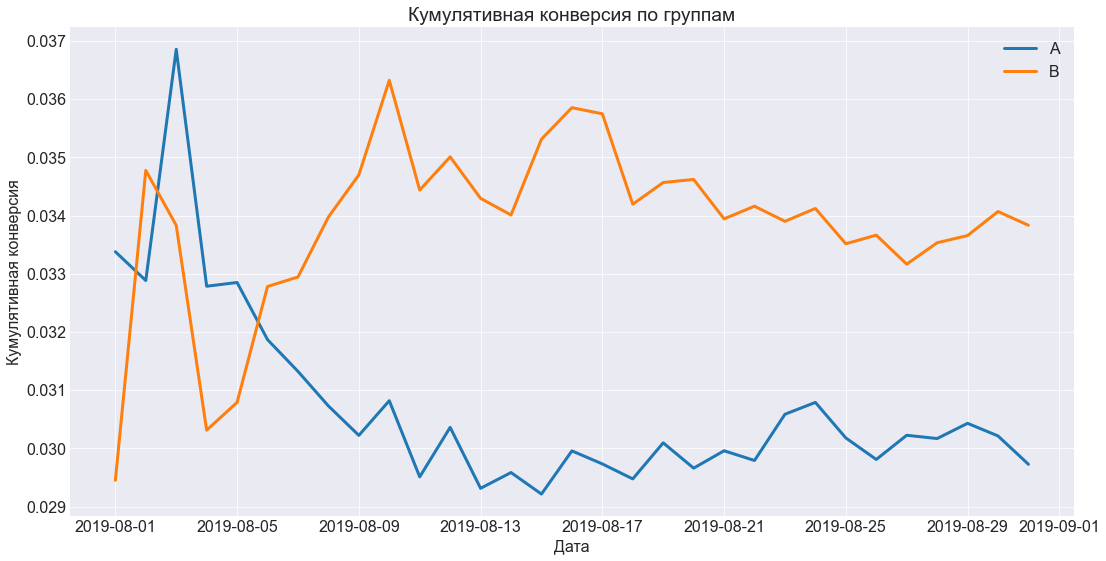

In [54]:
# построим график кумулятивной конверсии по группам 
fig, ax = plt.subplots()
plt.title('Кумулятивная конверсия по группам')
ax = sns.lineplot(x = 'date',
                  y = 'conversion',
                  data = cumulative_data_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'conversion',
                  data = cumulative_data_B,
                  label = 'B',
                  linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
ax.legend()
plt.show()

Без установления масштаба кажется, что конверсия постоянно колеблется, однако заметно, что колебания с 09.08.2019 несущественны для обеих групп (менее 0,5%). Для наглядности изменим масштаб графика.

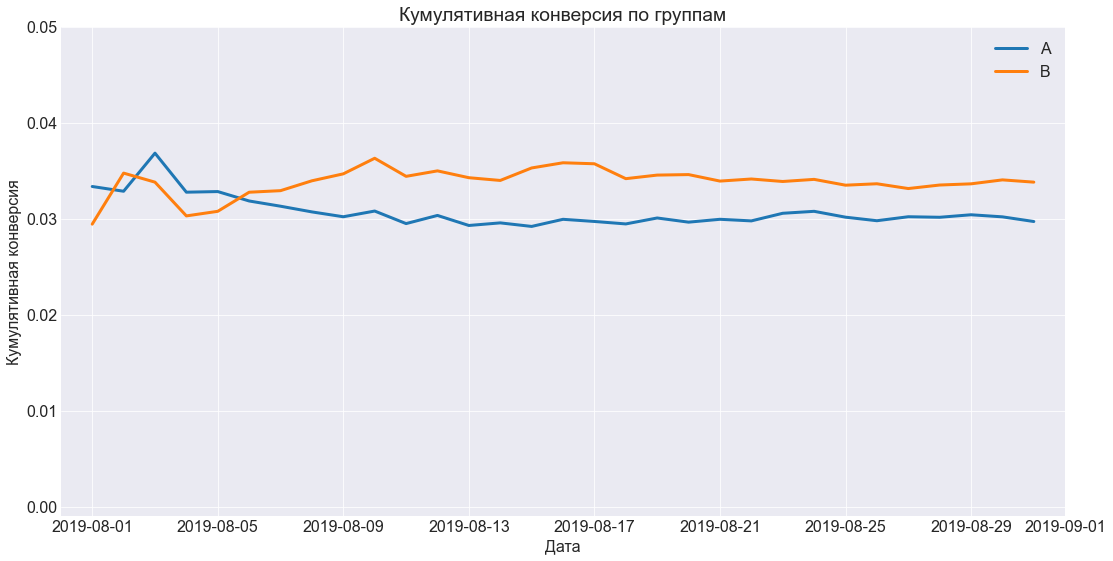

In [55]:
# построим график кумулятивной конверсии по группам 
fig, ax = plt.subplots()
plt.title('Кумулятивная конверсия по группам')
ax = sns.lineplot(x = 'date',
                  y = 'conversion',
                  data = cumulative_data_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'conversion',
                  data = cumulative_data_B,
                  label = 'B',
                  linewidth = 3)
plt.axis([pd.to_datetime('2019-07-31'),
          pd.to_datetime('2019-09-01'),
          -0.001, 0.05])
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
ax.legend()
plt.show()

В начале теста группа A имела большую конверсию, однако после 06.08.2019 кумулятивная конверсия группы B ее опередила. Примерно с 10.08.2019 конверсии обеих групп установились на определённом уровне с явным преобладанием кумулятивной конверсии группы B над кумулятивной конверсией группы A.

##### Построить график относительного изменения кумулятивной конверсии группы B к группе A   

In [56]:
# объединим данные в одном датафрейме
merged_cumulative_conversions = cumulative_data_A[['date',
                                                   'conversion']].merge(cumulative_data_B[['date',
                                                                                          'conversion']],
                                                                        left_on = 'date',
                                                                        right_on = 'date',
                                                                        how = 'left',
                                                                        suffixes = ['A', 'B'])
merged_cumulative_conversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.03,0.03
1,2019-08-02,0.03,0.03
2,2019-08-03,0.04,0.03
3,2019-08-04,0.03,0.03
4,2019-08-05,0.03,0.03


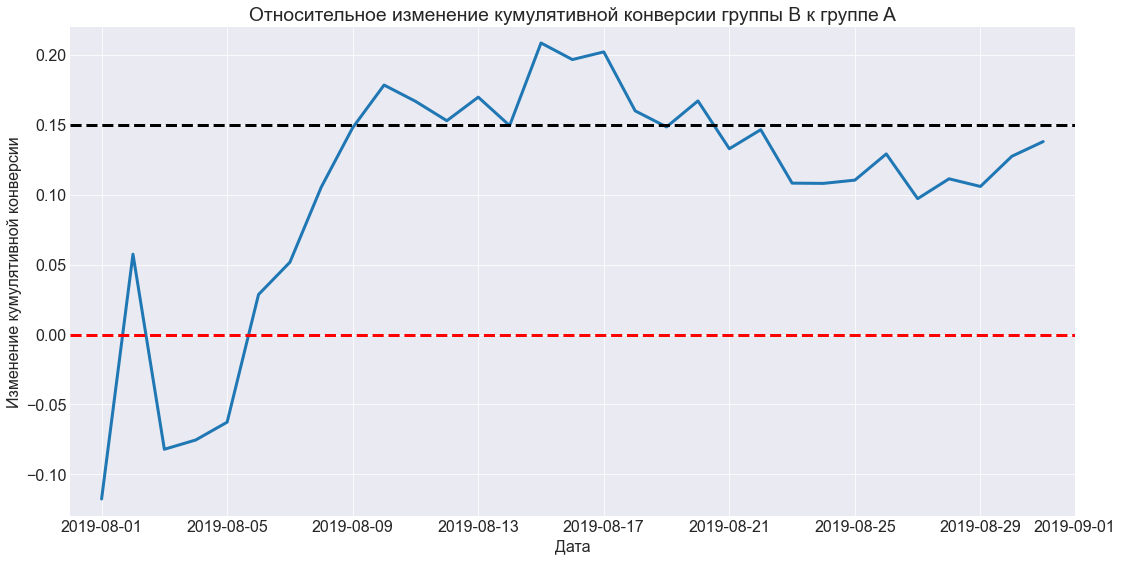

In [57]:
# построим график относительного изменения кумулятивной конверсии группы B к группе A 
merged_cumulative_conversions['conversion_relation'] = merged_cumulative_conversions['conversionB']\
                                                     / merged_cumulative_conversions['conversionA'] - 1
fig, ax = plt.subplots()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
ax = sns.lineplot(x = 'date',
                  y = 'conversion_relation',
                  data = merged_cumulative_conversions,
                  linewidth = 3)
plt.axhline(y = 0,
            color = 'red',
            linestyle = '--',
            linewidth = 3)
plt.axhline(y = 0.15,
            color = 'black',
            linestyle = '--',
            linewidth = 3)
plt.axis([pd.to_datetime('2019-07-31'),
          pd.to_datetime('2019-09-01'),
          -0.13, 0.22])
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивной конверсии')
plt.show()

Примерно с 06.08.2019 группа B лидирует по конверсии и с середины теста превосходит группу A приблизительно на 15%, однако к концу теста намечается тенденция к снижению. В целом отношение конверсий ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Необходимо проанализировать аномалии, возможно, они изменят картину.

##### Построить точечный график количества заказов по пользователям   

In [58]:
# создадим таблицу с количеством заказов по пользователям
orders_by_users = orders.drop(['group',
                               'revenue',
                               'date'],
                              axis = 1)\
                        .groupby('visitor_id',
                                 as_index = False)\
                        .agg({'transaction_id' : pd.Series.nunique})
orders_by_users.columns = ['visitor_id',
                           'orders']
orders_by_users.sort_values(by = 'orders',
                            ascending = False)\
               .head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


10 пользователей совершили от 5 заказов и более.

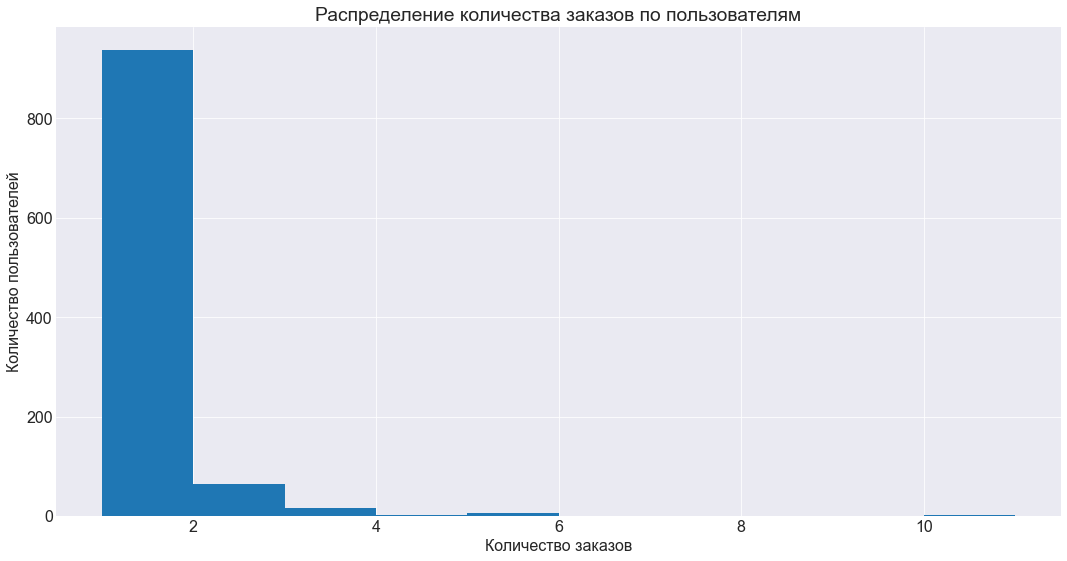

In [59]:
# посмотрим на распределение количества заказов по пользователям
fig, ax = plt.subplots()
ax.set(title = 'Распределение количества заказов по пользователям',
       xlabel = 'Количество заказов',
       ylabel = 'Количество пользователей')
ax.hist(orders_by_users['orders'])
plt.show()

Большинство покупателей заказывали только один раз, однако доля пользователей с 2-3 заказами тоже значительна.

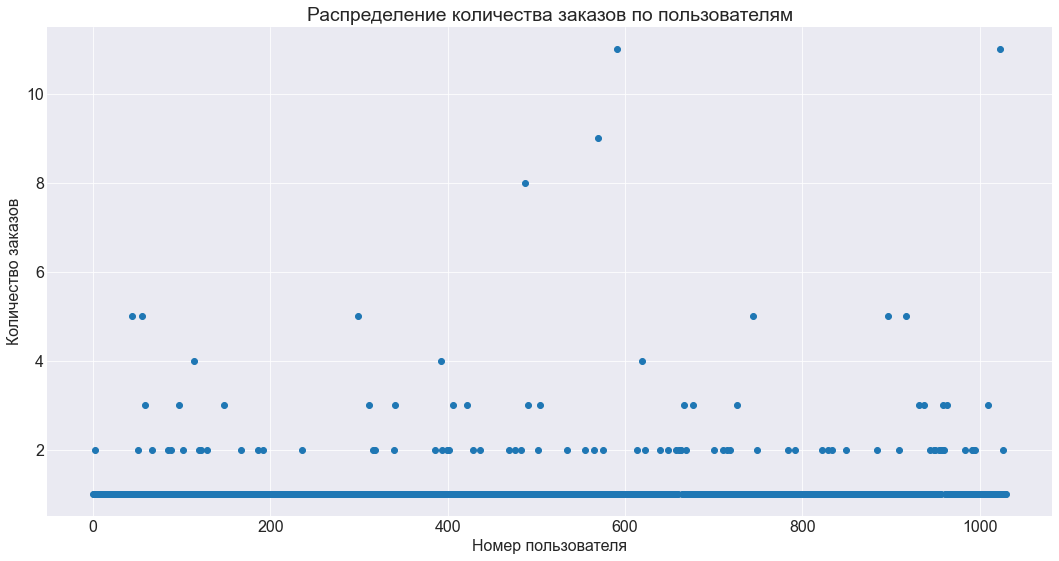

In [60]:
# построим точечную диаграмму числа заказов по пользователям
fig, ax = plt.subplots()
ax.set(title = 'Распределение количества заказов по пользователям',
       xlabel = 'Номер пользователя',
       ylabel = 'Количество заказов')
x_values = pd.Series(range(0, len(orders_by_users)))
ax.scatter(x_values,
           orders_by_users['orders'])
plt.show()

Выводы подтверждаются: много пользователей с 2-3 заказами, их точная доля неизвестна — непонятно, считать их аномалиями или нет.

##### Посчитать 95-й и 99-й перцентили количества заказов на пользователя, выбрать границу для определения аномальных пользователей   

In [61]:
# посчитаем перцентили количества заказов на пользователя
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше, чем 2 заказа, и 1% пользователей - 4 и более. Выберем 2 заказа на одного пользователя за нижнюю границу числа заказов, чтобы отсеять аномальных пользователей по ней.

##### Построить точечный график стоимостей заказов  

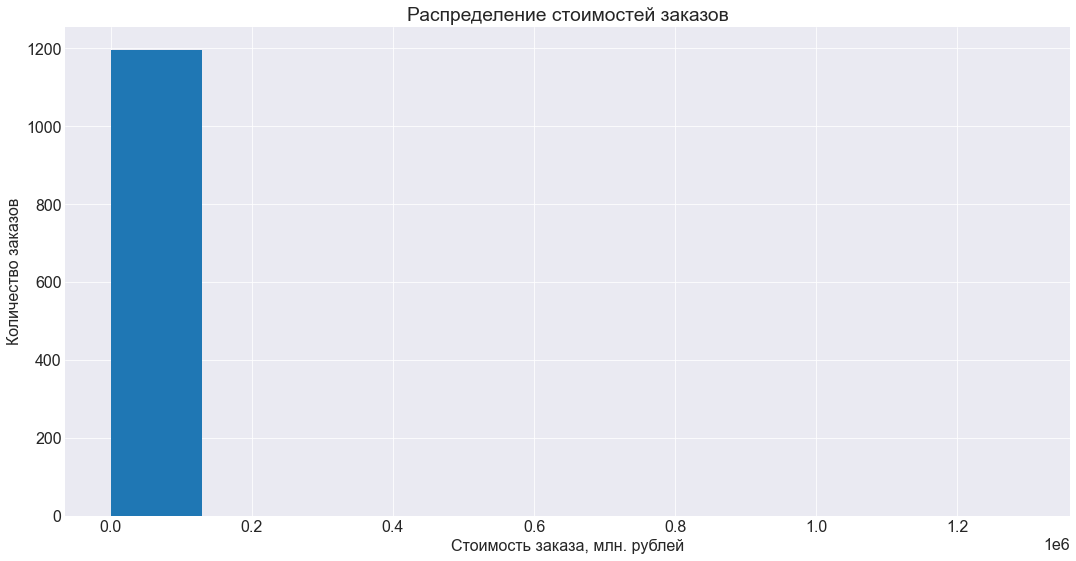

In [62]:
# посмотрим на распределение стоимостей заказов
fig, ax = plt.subplots()
ax.set(title = 'Распределение стоимостей заказов',
       xlabel = 'Стоимость заказа, млн. рублей',
       ylabel = 'Количество заказов')
ax.hist(orders['revenue'])
plt.show()

Большинство заказов до 15000 рублей, однако есть и крупные заказы - более 1 млн.рублей.

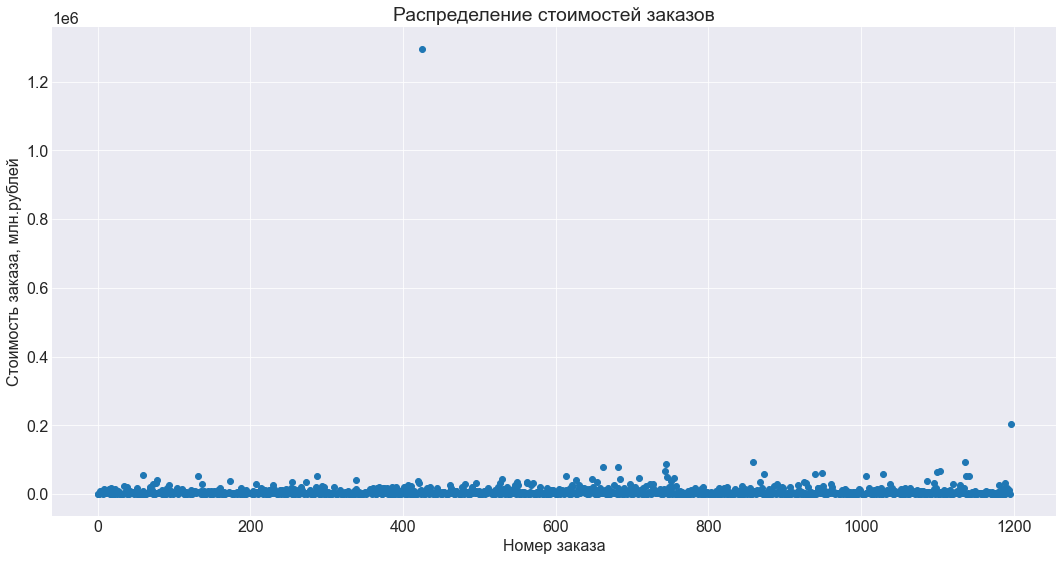

In [63]:
# построим точечную диаграмму стоимостей заказов
fig, ax = plt.subplots()
ax.set(title = 'Распределение стоимостей заказов',
       xlabel = 'Номер заказа',
       ylabel = 'Стоимость заказа, млн.рублей')
x_values = pd.Series(range(0, len(orders)))
ax.scatter(x_values,
           orders['revenue'])
plt.show()

Есть 2 аномальных заказа - стоимостью более 1,2 млн.рублей и около 200 тысяч рублей. Для большей наглядности уменьшим максимальный размер выручки на диаграмме до 200 тысяч рублей.

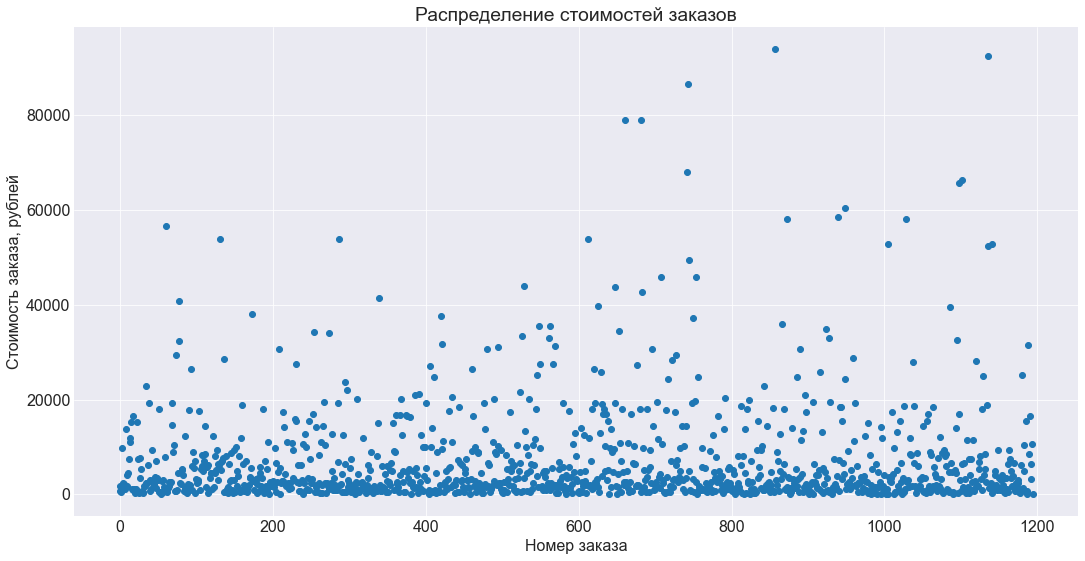

In [64]:
# построим точечную диаграмму стоимостей заказов с укрупненным масштабом
fig, ax = plt.subplots()
ax.set(title = 'Распределение стоимостей заказов',
       xlabel = 'Номер заказа',
       ylabel = 'Стоимость заказа, рублей')
x_values = pd.Series(range(0, len(orders[orders['revenue'] <= 200000])))
ax.scatter(x_values,
           orders[orders['revenue'] <= 200000]['revenue'])
plt.show()

Исходя из диаграммы, граница аномальных заказов между 20 и 40 тысячами рублей.

##### Посчитать 95-й и 99-й перцентили стоимости заказов, выбрать границу для определения аномальных заказов   

In [65]:
# посчитаем перцентили стоимости заказов
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28000 рублей, и 1% заказов - 58000 рублей. Выберем 30000 рублей за нижнюю границу стоимости заказа, чтобы отсеять аномальных пользователей по ней.

##### Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным   

Проведем подготовку данных.

In [66]:
# определим количество пользователей в выбранную дату в группе A
visitors_A_daily = visitors[visitors['group'] == 'A'][['date',
                                                       'visitors']]
visitors_A_daily.columns = ['date',
                            'visitors_per_dateA']
visitors_A_daily.head()

,date,visitors_per_dateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [67]:
# определим количество пользователей в выбранную дату в группе B
visitors_B_daily = visitors[visitors['group'] == 'B'][['date',
                                                       'visitors']]
visitors_B_daily.columns = ['date',
                            'visitors_per_dateB']
visitors_B_daily.head()

,date,visitors_per_dateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [68]:
# определим количество пользователей до выбранной даты включительно в группе A
visitors_A_cummulative = visitors_A_daily.apply(lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']]\
                                         .agg({'date' : 'max',
                                               'visitors_per_dateA' : 'sum'}),
                                                axis = 1)
visitors_A_cummulative.columns = ['date',
                                  'visitors_cummulativeA']
visitors_A_cummulative.head()

,date,visitors_cummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [69]:
# определим количество пользователей до выбранной даты включительно в группе B
visitors_B_cummulative = visitors_B_daily.apply(lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']]\
                                         .agg({'date' : 'max',
                                               'visitors_per_dateB' : 'sum'}),
                                                axis = 1)
visitors_B_cummulative.columns = ['date',
                                  'visitors_cummulativeB']
visitors_B_cummulative.head()

,date,visitors_cummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [70]:
# определим количество заказов и суммарную выручку в выбранную дату в группе A
orders_A_daily = orders[orders['group'] == 'A'][['date',
                                                 'transaction_id',
                                                 'visitor_id',
                                                 'revenue']].groupby('date',
                                                                     as_index = False)\
                                                            .agg({'transaction_id' : pd.Series.nunique,
                                                                  'revenue' : 'sum'})
orders_A_daily.columns = ['date',
                          'orders_per_dateA',
                          'revenue_per_dateA']
orders_A_daily.head()

,date,orders_per_dateA,revenue_per_dateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [71]:
# определим количество заказов и суммарную выручку в выбранную дату в группе B
orders_B_daily = orders[orders['group'] == 'B'][['date',
                                                 'transaction_id',
                                                 'visitor_id',
                                                 'revenue']].groupby('date',
                                                                     as_index = False)\
                                                            .agg({'transaction_id' : pd.Series.nunique,
                                                                  'revenue' : 'sum'})
orders_B_daily.columns = ['date',
                          'orders_per_dateB',
                          'revenue_per_dateB']
orders_B_daily.head()

,date,orders_per_dateB,revenue_per_dateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [72]:
# определим количество заказов и суммарную выручку до выбранной даты включительно в группе A
orders_A_cummulative = orders_A_daily.apply(lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']]\
                                     .agg({'date' : 'max',
                                           'orders_per_dateA' : 'sum',
                                           'revenue_per_dateA' : 'sum'}),
                                            axis = 1)\
                                     .sort_values(by = ['date'])
orders_A_cummulative.columns = ['date',
                                'orders_cummulativeA',
                                'revenue_cummulativeA']
orders_A_cummulative.head()

,date,orders_cummulativeA,revenue_cummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [73]:
# определим количество заказов и суммарную выручку до выбранной даты включительно в группе B
orders_B_cummulative = orders_B_daily.apply(lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']]\
                                     .agg({'date' : 'max',
                                           'orders_per_dateB' : 'sum',
                                           'revenue_per_dateB' : 'sum'}),
                                            axis = 1)\
                                     .sort_values(by = ['date'])
orders_B_cummulative.columns = ['date',
                                'orders_cummulativeB',
                                'revenue_cummulativeB']
orders_B_cummulative.head()

,date,orders_cummulativeB,revenue_cummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [74]:
# объединим все полученные таблицы
data = orders_A_daily.merge(orders_B_daily,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')\
                     .merge(orders_A_cummulative,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')\
                     .merge(orders_B_cummulative,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')\
                     .merge(visitors_A_daily,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')\
                     .merge(visitors_B_daily,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')\
                     .merge(visitors_A_cummulative,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')\
                     .merge(visitors_B_cummulative,
                            left_on = 'date',
                            right_on = 'date',
                            how = 'left')
data.head()

,date,orders_per_dateA,revenue_per_dateA,orders_per_dateB,revenue_per_dateB,orders_cummulativeA,revenue_cummulativeA,orders_cummulativeB,revenue_cummulativeB,visitors_per_dateA,visitors_per_dateB,visitors_cummulativeA,visitors_cummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [75]:
# определим число совершённых заказов для пользователей, которые заказывали хотя бы 1 раз, в группе A 
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitor_id',
                                                           as_index = False)\
                                                  .agg({'transaction_id' : pd.Series.nunique})
orders_by_users_A.columns = ['visitor_id',
                             'orders']
orders_by_users_A.head()

,visitor_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [76]:
# определим число совершённых заказов для пользователей, которые заказывали хотя бы 1 раз, в группе B 
orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitor_id',
                                                           as_index = False)\
                                                  .agg({'transaction_id' : pd.Series.nunique})
orders_by_users_B.columns = ['visitor_id',
                             'orders']
orders_by_users_B.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [77]:
# объявим переменную, в которой пользователям из группы A будет соответствовать количество заказов
sample_A = pd.concat([orders_by_users_A['orders'],
                      pd.Series(0, index = np.arange(data['visitors_per_dateA'].sum()\
                                                     - len(orders_by_users_A['orders'])),
                                name = 'orders')],
                     axis = 0)
sample_A.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [78]:
# объявим переменную, в которой пользователям из группы B будет соответствовать количество заказов
sample_B = pd.concat([orders_by_users_B['orders'],
                      pd.Series(0, index = np.arange(data['visitors_per_dateB'].sum()\
                                                     - len(orders_by_users_B['orders'])),
                                name = 'orders')],
                     axis = 0)
sample_A.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Учитывая ненормальность распределения исходных данных, для расчета статистической значимости применим тест Манна-Уитни. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей и выведем относительный прирост конверсии группы B.

Сформулируем гипотезы:  
Н0 - различий в конверсии групп A и B нет.    
Н1 - различия в конверсии групп A и B есть.

In [79]:
# посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным
print('Значение p-value для конверсии: {:.3f}'.format(stats.mannwhitneyu(sample_A,
                                                                         sample_B,
                                                                         alternative = 'two-sided')[1]))
print('Относительный прирост конверсии группы B: {:.1%}'.format(sample_B.mean() / sample_A.mean() -1))

Значение p-value для конверсии: 0.017
Относительный прирост конверсии группы B: 13.8%


P-value меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "сырых" данных показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A равен 13,8%.

##### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным   

Учитывая ненормальность распределения исходных данных, для расчета статистической значимости применим тест Манна-Уитни. Также, как и при анализе конверсий, найдем относительные различия в среднем чеке между группами.

Сформулируем гипотезы:  
Н0 - различий в среднем чеке групп A и B нет.    
Н1 - различия в среднем чеке групп A и B есть.

In [80]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
print('Значение p-value для среднего чека: {:.3f}'.format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],
                                                                             orders[orders['group'] == 'B']['revenue'],
                                                                             alternative = 'two-sided')[1]))
print('Относительный прирост среднего чека группы B: {:.1%}'.format(orders[orders['group'] == 'B']['revenue'].mean()\
                                                                    / orders[orders['group'] == 'A']['revenue'].mean() -1))

Значение p-value для среднего чека: 0.729
Относительный прирост среднего чека группы B: 25.9%


P-value больше 0,05, поэтому нулевую гипотезу оставляем. Анализ "сырых" данных показывает, что в среднем чеке между группами нет статистически значимых различий. Вместе с тем, относительный прирост среднего чека группы B к среднему чеку группы A равен 25,9%.

##### Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным     

In [81]:
# сделаем срезы с аномальными пользователями
users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A['orders'] > 2]['visitor_id'],
                                    orders_by_users_B[orders_by_users_B['orders'] > 2]['visitor_id']],
                                   axis = 0)
users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']
abnormal_users = pd.concat([users_with_many_orders,
                            users_with_expensive_orders],
                           axis = 0)\
                   .drop_duplicates()\
                   .sort_values()
abnormal_users.head() 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64

In [82]:
# посчитаем количество аномальных пользователей
abnormal_users.shape

(68,)

Всего 68 аномальных пользователей. Посмотрим, как их действия повлияли на результат теста.

In [83]:
# объявим переменную, в которой пользователям из группы A будет соответствовать количество заказов
sample_A_filtered = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A['visitor_id']\
                                                                .isin(abnormal_users))]['orders'],
                               pd.Series(0, index = np.arange(data['visitors_per_dateA'].sum()\
                                                              - len(orders_by_users_A['orders'])),
                                         name = 'orders')],
                              axis = 0)
sample_A_filtered.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [84]:
# объявим переменную, в которой пользователям из группы B будет соответствовать количество заказов
sample_B_filtered = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B['visitor_id']\
                                                                .isin(abnormal_users))]['orders'],
                               pd.Series(0, index = np.arange(data['visitors_per_dateB'].sum()\
                                                              - len(orders_by_users_B['orders'])),
                                         name = 'orders')],
                              axis = 0)
sample_B_filtered.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Сформулируем гипотезы:  
Н0 - различий в конверсии групп A и B нет.    
Н1 - различия в конверсии групп A и B есть.

In [85]:
# посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным
print('Значение p-value для конверсии: {:.3f}'.format(stats.mannwhitneyu(sample_A_filtered,
                                                                         sample_B_filtered,
                                                                         alternative = 'two-sided')[1]))
print('Относительный прирост конверсии группы B: {:.1%}'.format(sample_B_filtered.mean() / sample_A_filtered.mean() -1))

Значение p-value для конверсии: 0.013
Относительный прирост конверсии группы B: 17.2%


P-value меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "очищенных" данных также показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A по "очищенным" данным увеличился и равен 17,2%.

##### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным   

Сформулируем гипотезы:  
Н0 - различий в среднем чеке групп A и B нет.    
Н1 - различия в среднем чеке групп A и B есть.

In [86]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
print('Значение p-value для среднего чека: {:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                                                                    np.logical_not(orders['visitor_id']\
                                                                                      .isin(abnormal_users)))]['revenue'],
                                                                             orders[np.logical_and(orders['group'] == 'B',
                                                                                    np.logical_not(orders['visitor_id']\
                                                                                      .isin(abnormal_users)))]['revenue'],
                                                                            alternative = 'two-sided')[1]))
print('Относительный прирост среднего чека группы B: {:.1%}'.format(orders[np.logical_and(orders['group'] == 'B',
                                                                           np.logical_not(orders['visitor_id']\
                                                                             .isin(abnormal_users)))]['revenue'].mean()\
                                                                  / orders[np.logical_and(orders['group'] == 'A',
                                                                           np.logical_not(orders['visitor_id']\
                                                                             .isin(abnormal_users)))]['revenue'].mean() - 1)) 

Значение p-value для среднего чека: 0.720
Относительный прирост среднего чека группы B: -2.3%


P-value больше 0,05, поэтому нулевую гипотезу оставляем. Анализ "очищенных" данных также показывает, что в среднем чеке между группами нет статистически значимых различий. Вместе с тем, без аномальных пользователей средний чек группы B стал меньше среднего чека группы A - на 2,3%.

##### Принять решение по результатам теста

Построим графики для кумулятивной выручки, среднего чека и конверсии по "очищенным" данным.

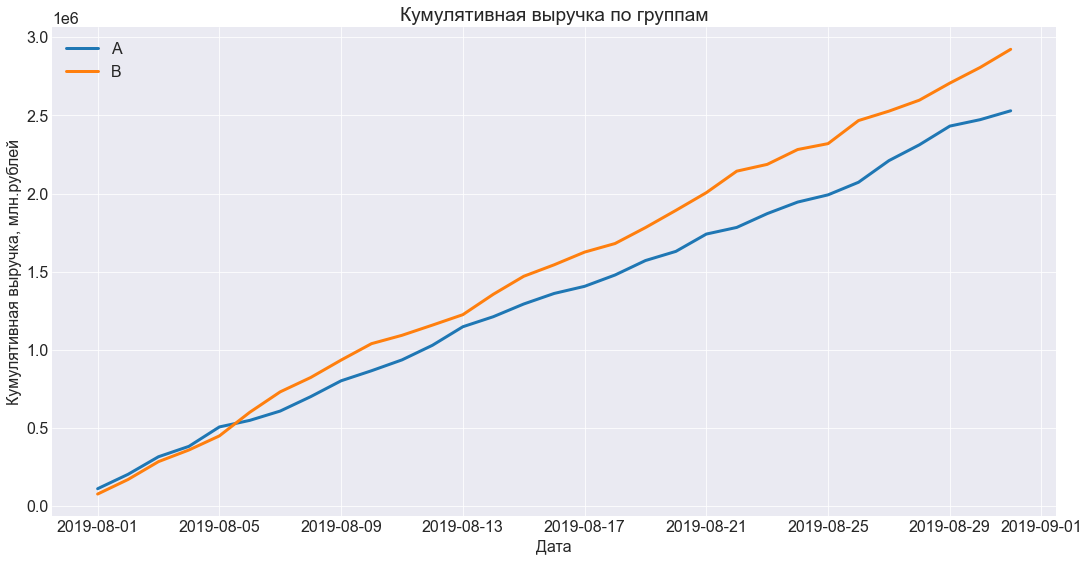

In [87]:
# построим график кумулятивной выручки по группам по "очищенным" данным
orders_filtered = orders[~orders['visitor_id'].isin(abnormal_users)]
abnormal_visitors = (orders.groupby(['date', 'group'])['visitor_id'].count()\
                     - orders_filtered.groupby(['date', 'group'])\
                       ['visitor_id'].count())\
                                     .reset_index()\
                                     .rename(columns = {'visitor_id' : 'abnormal_visitors'})
visitors_filtered = visitors.copy()
visitors_filtered['visitors'] = visitors_filtered['visitors'] - abnormal_visitors['abnormal_visitors']
dates_groups_filtered = orders_filtered[['date',
                                         'group']].drop_duplicates()
orders_aggregated_filtered = dates_groups_filtered.apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date']\
                                                                                                  <= x['date'],
                                                                                                  orders_filtered['group']\
                                                                                                  == x['group'])]\
                                                 .agg({'date' : 'max',
                                                       'group' : 'max',
                                                       'transaction_id' : pd.Series.nunique,
                                                       'visitor_id' : pd.Series.nunique,
                                                       'revenue' : 'sum'}),
                                                       axis = 1)\
                                                 .sort_values(by = ['date',
                                                                    'group'])
visitors_aggregated_filtered = dates_groups_filtered.apply(lambda x: visitors_filtered[np.logical_and(visitors_filtered['date']\
                                                                                                      <= x['date'],
                                                                                                      visitors_filtered['group']\
                                                                                                      == x['group'])]\
                                                    .agg({'date' : 'max',
                                                          'group' : 'max',
                                                          'visitors' : 'sum'}),
                                                          axis = 1)\
                                                    .sort_values(by = ['date',
                                                                       'group'])
cumulative_data_filtered = orders_aggregated_filtered.merge(visitors_aggregated_filtered,
                                                            left_on = ['date',
                                                                       'group'],
                                                            right_on = ['date',
                                                                        'group'])
cumulative_data_filtered.columns = ['date',
                                    'group',
                                    'orders',
                                    'buyers',
                                    'revenue',
                                    'visitors']
cumulative_revenue_filtered_A = cumulative_data_filtered[cumulative_data_filtered['group'] == 'A'][['date',
                                                                                                    'revenue',
                                                                                                    'orders']]
cumulative_revenue_filtered_B = cumulative_data_filtered[cumulative_data_filtered['group'] == 'B'][['date',
                                                                                                    'revenue',
                                                                                                    'orders']]     
fig, ax = plt.subplots()
plt.title('Кумулятивная выручка по группам')
ax = sns.lineplot(x = 'date',
                  y = 'revenue',
                  data = cumulative_revenue_filtered_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'revenue',
                  data = cumulative_revenue_filtered_B,
                  label = 'B',
                  linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, млн.рублей')
ax.legend()
plt.show() 

Без учета аномальных пользователей с 06.08.2019 разница кумулятивной выручки между группами с каждым днем становится больше, преимущество группы B очевидно.

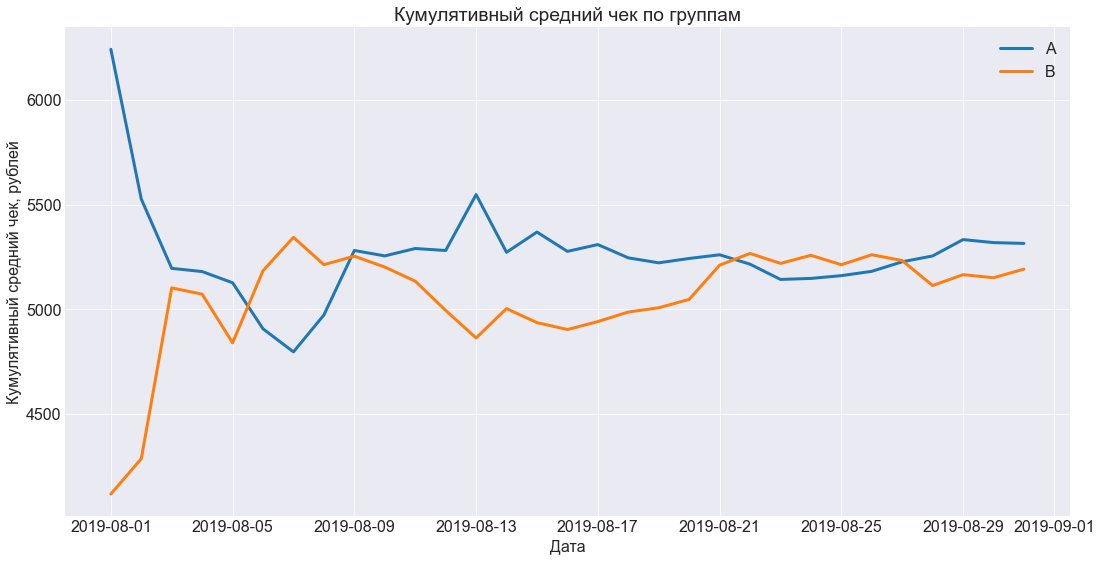

In [88]:
# построим график кумулятивного среднего чека по группам по "очищенным" данным
cumulative_revenue_filtered_A['fee_mean'] = cumulative_revenue_filtered_A['revenue'] / cumulative_revenue_filtered_A['orders']
cumulative_revenue_filtered_B['fee_mean'] = cumulative_revenue_filtered_B['revenue'] / cumulative_revenue_filtered_B['orders']
fig, ax = plt.subplots()
plt.title('Кумулятивный средний чек по группам')
ax = sns.lineplot(x = 'date',
                  y = 'fee_mean',
                  data = cumulative_revenue_filtered_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'fee_mean',
                  data = cumulative_revenue_filtered_B,
                  label = 'B',
                  linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, рублей')
ax.legend()
plt.show()

Графики динамики среднего чека без учета аномальных пользователей к концу теста практически успокоились в обеих группах, чье-либо преимущество неочевидно.

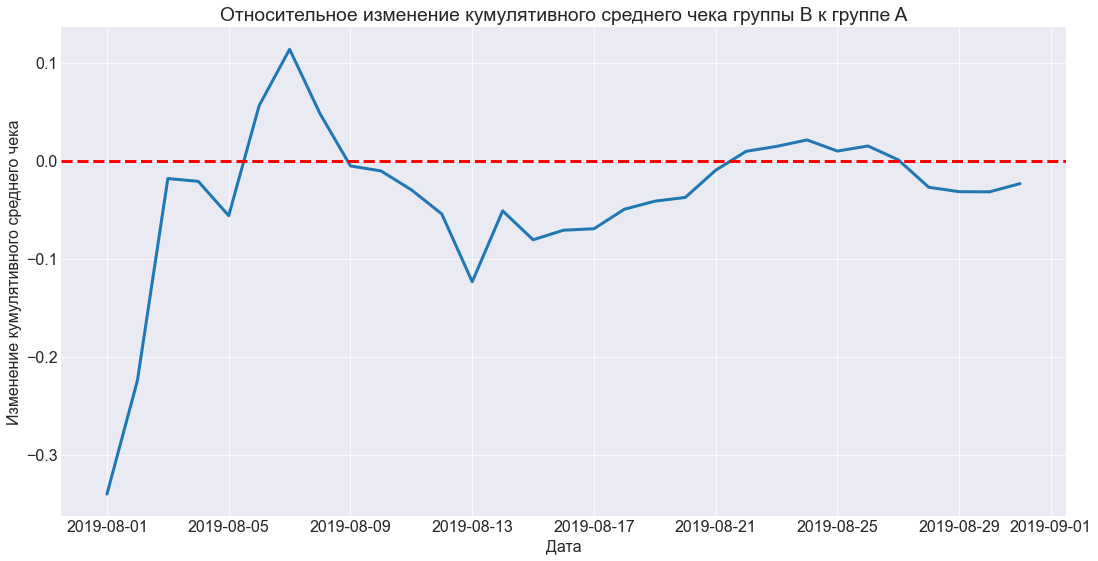

In [89]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A по "очищенным" данным
merged_cumulative_revenue_filtered = cumulative_revenue_filtered_A.merge(cumulative_revenue_filtered_B,
                                                                         left_on = 'date',
                                                                         right_on = 'date',
                                                                         how = 'left',
                                                                         suffixes = ['A', 'B'])
merged_cumulative_revenue_filtered['fee_relation'] = merged_cumulative_revenue_filtered['fee_meanB']\
                                                    / merged_cumulative_revenue_filtered['fee_meanA'] - 1
fig, ax = plt.subplots()
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
ax = sns.lineplot(x = 'date',
                  y = 'fee_relation',
                  data = merged_cumulative_revenue_filtered,
                  linewidth = 3)
plt.axhline(y = 0,
            color = 'red',
            linestyle = '--',
            linewidth = 3)
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивного среднего чека')
plt.show()

Преимущество какой-либо группы по среднему чеку практически отсутствует.

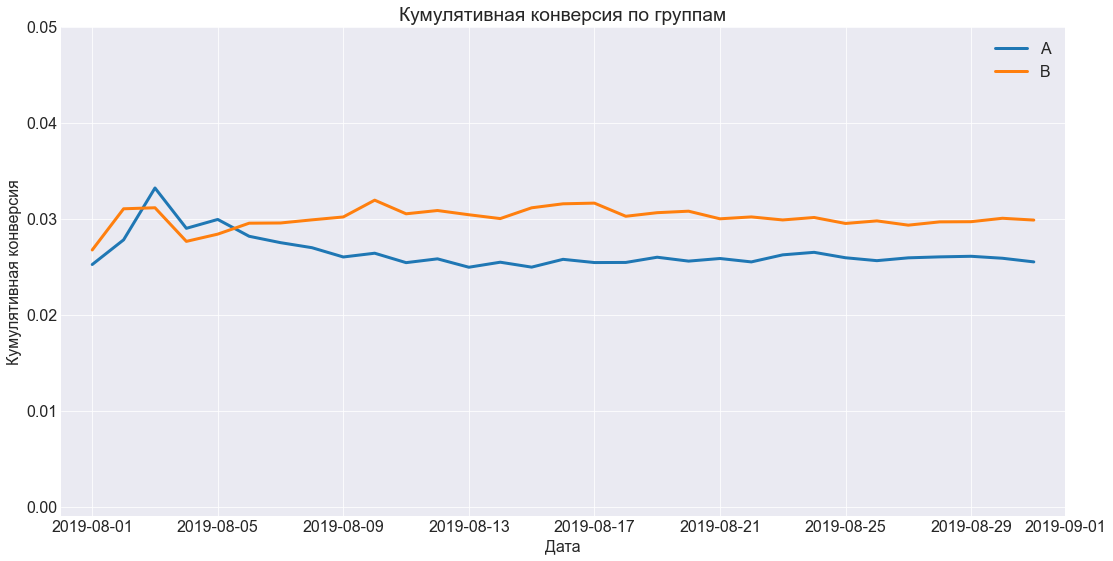

In [90]:
# построим график кумулятивной конверсии по группам по "очищенным" данным
cumulative_data_filtered['conversion'] = cumulative_data_filtered['orders'] / cumulative_data_filtered['visitors']
cumulative_data_filtered_A = cumulative_data_filtered[cumulative_data_filtered['group'] == 'A']
cumulative_data_filtered_B = cumulative_data_filtered[cumulative_data_filtered['group'] == 'B']
fig, ax = plt.subplots()
plt.title('Кумулятивная конверсия по группам')
ax = sns.lineplot(x = 'date',
                  y = 'conversion',
                  data = cumulative_data_filtered_A,
                  label = 'A',
                  linewidth = 3)
ax = sns.lineplot(x = 'date',
                  y = 'conversion',
                  data = cumulative_data_filtered_B,
                  label = 'B',
                  linewidth = 3)
plt.axis([pd.to_datetime('2019-07-31'),
          pd.to_datetime('2019-09-01'),
          -0.001, 0.05])
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
ax.legend()
plt.show()

Примерно с 10.08.2019 в кумулятивной конверсии установилось явное преимущество группы B.

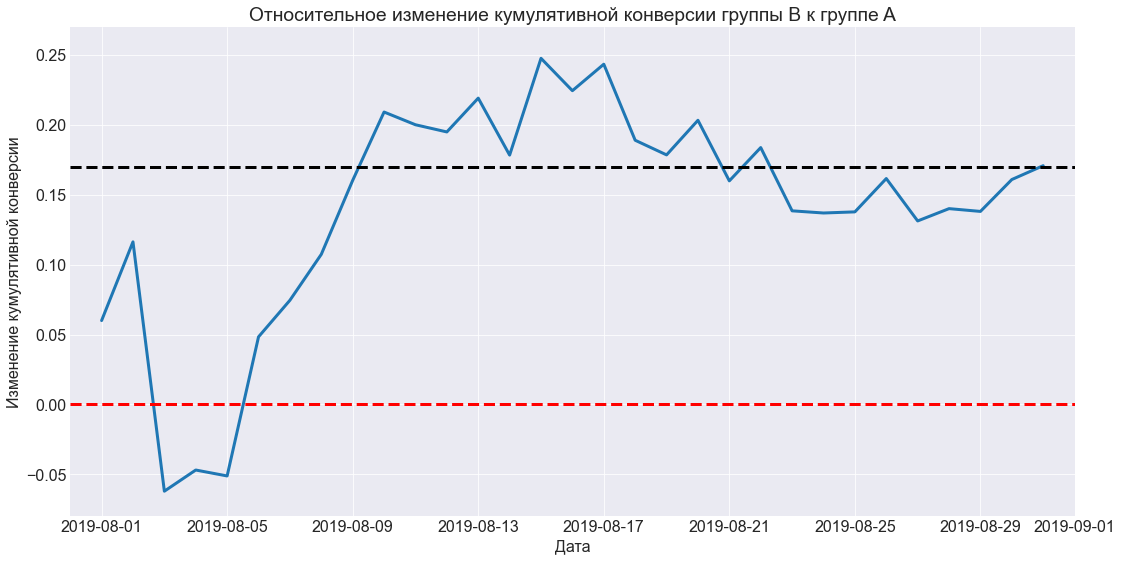

In [91]:
# построим график относительного изменения кумулятивной конверсии группы B к группе A по "очищенным" данным
merged_cumulative_conversions_filtered = cumulative_data_filtered_A[['date',
                                                                     'conversion']].merge(cumulative_data_filtered_B[['date',
                                                                                                                      'conversion']],
                                                                                          left_on = 'date',
                                                                                          right_on = 'date',
                                                                                          how = 'left',
                                                                                          suffixes = ['A', 'B'])
merged_cumulative_conversions_filtered['conversion_relation'] = merged_cumulative_conversions_filtered['conversionB']\
                                                     / merged_cumulative_conversions_filtered['conversionA'] - 1
fig, ax = plt.subplots()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
ax = sns.lineplot(x = 'date',
                  y = 'conversion_relation',
                  data = merged_cumulative_conversions_filtered,
                  linewidth = 3)
plt.axhline(y = 0,
            color = 'red',
            linestyle = '--',
            linewidth = 3)
plt.axhline(y = 0.17,
            color = 'black',
            linestyle = '--',
            linewidth = 3)
plt.axis([pd.to_datetime('2019-07-31'),
          pd.to_datetime('2019-09-01'),
          -0.08, 0.27])
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивной конверсии')
plt.show()

Преимущество группы B по конверсии около 17%,без аномальных пользователей тенденция к уменьшению различий конверсий между группами отсутствует.

В результате проведенного исследования:  
- есть статистически значимое различие между группами по конверсии  как по "сырым", так и по "очищенным" от аномальных значений данным;
- нет статистически значимого различия между группами по среднему чеку ни по "сырым", ни по "очищенным" от аномальных значений данным;
- конверсии обеих групп установились на определённом уровне с преобладанием кумулятивной конверсии группы B над кумулятивной конверсией группы A приблизительно на 15%, что в абсолютных значениях составляет около 0,5%;
- без аномальных пользователей разница в среднем чеке между группами практически отсутствует;   
- выручка группы B явно выше, чем группы A, при этом разница увеличивается с каждым днем.

Исходя из установленных фактов, тест следует остановить и зафиксировать победу группы B. Показатели выручки пользователей группы B явно выше за счет различий в конверсиях.  В то же время, следует иметь ввиду, что 5,6% пользователей при осуществлении заказов были отнесены к разным группам, что негативно влияет на качество A/B теста.

#### Вывод

58 пользователей (5,6%) попало в две разные группы (группу A и группу B), этими пользователями совершено 15,1% заказов. Для большей достоверности A/B-теста их следовало бы исключить, однако в таблице `visitors` эти пользователи попали в обе группы, причём неизвестно, в какие даты. По этой причине данные с пользователями, попавшими в две разные группы, в выборках оставили. 
Распределение выручки не нормально, следовательно для проверки гипотез при A/B-тестировании необходимо применить непараметрический тест - критерий Манна-Уитни.   
Выручка у покупателей из обеих групп почти равномерно увеличивалась до середины теста. Затем сегмент B вырвался вперед и продолжал лидировать до конца теста. При этом график выручки группы B в нескольких точках резко растет. Это говорит о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Кроме того, в группе B большее количество пользователей.    
Средний чек в группе A становится равномерным примерно с середины теста, а в группе B после значительного всплеска начинает медленно уменьшаться (имеются выбросы, которые искажают результаты).   
В нескольких точках график различия среднего чека между группами резко «скачет», максимальные всплески были 06.08. и 19.08.2019. Вероятнее всего именно в эти дни и были совершены аномальные заказы.  
Без установления масштаба кажется, что конверсия постоянно колеблется, однако заметно, что колебания с 09.08.2019 несущественны для обеих групп (менее 0,5%). При изменении масштаба видно, что в начале теста группа A имела большую конверсию, однако после 06.08.2019 кумулятивная конверсия группы B ее опередила. Примерно с 10.08.2019 конверсии обеих групп установились на определённом уровне с явным преобладанием кумулятивной конверсии группы B над кумулятивной конверсией группы A.  
Примерно с 06.08.2019 группа B лидирует по конверсии и с середины теста превосходит группу A приблизительно на 15%, однако к концу теста намечается тенденция к снижению.   
Были выбраны 2 заказа на одного пользователя за нижнюю границу числа заказов, 30000 рублей за нижнюю границу стоимости заказа, чтобы отсеять аномальных пользователей по ним (всего установлено 68 аномальных пользователей).    
Анализ и "сырых", и  "очищенных" данных показывает, что в конверсии между группами есть статистически значимые различия, а в среднем чеке между группами нет статистически значимых различий. Относительный прирост конверсии группы B к конверсии группы A по "сырым" данным равен 13,8%, по "очищенным" - 17,2%. Относительный прирост среднего чека группы B к среднему чеку группы A по "сырым" данным равен 25,9%, а по "очищенным" - -2,3%.    
Без учета аномальных пользователей с 06.08.2019 разница кумулятивной выручки между группами с каждым днем становится больше, преимущество группы B очевидно. Графики динамики среднего чека к концу теста практически успокоились в обеих группах, чье-либо преимущество неочевидно. Примерно с 10.08.2019 в кумулятивной конверсии установилось явное преимущество группы B.    
Исходя из установленных фактов, тест следует остановить и зафиксировать победу группы B. Показатели выручки пользователей группы B явно выше за счет различий в конверсиях.  В то же время, следует иметь ввиду, что 5,6% пользователей при осуществлении заказов были отнесены к разным группам, что негативно влияет на качество A/B теста.

### Общий вывод
<a name="conclusion"></a>

Наиболее приоритетными гипотезами (по порядку уменьшения приоритета) являются:  
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.   
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.  
5. Запустить акцию, дающую скидку на товар в день рождения.   

A/B тест следует остановить и и зафиксировать победу группы B. Показатели выручки пользователей группы B явно выше за счет различий в конверсиях.

### Рекомендации
<a name="recommendations"></a>

1. Для увеличения выручки интернет-магазина использовать вышеперечисленные в порядке приоритета гипотезы.   
2. При подготовке A/B тестов обращать внимание на равномерность распределения пользователей между группами, а также не допускать возможности попадания одних и тех же пользователей в разные группы.  
3. Запущенный A/B тест остановить и зафиксировать победу группы B.